In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind, ttest_rel, pearsonr
from sklearn import preprocessing

In [ ]:
# Get data on Currency Changes from Yahoo Finance for 5 years
#currency_data = yf.Ticker("EURUSD=X")
#df_currency = currency_data.history(period="5y")

# Export the data to a csv file 
#path = '../Data/eur_usd_exchange_rate.csv'
#df_currency.to_csv(path)

(1306, 7)


In [ ]:
# Preprocessing data

# Convert to datetime
stock_df['Date'] = pd.to_datetime(stock_df['Date'], errors='coerce')
currency_df['Date'] = pd.to_datetime(currency_df['Date'], errors='coerce')

# Remove invalid Date
stock_df = stock_df.dropna(subset=['Date'])
currency_df = currency_df.dropna(subset=['Date'])

# Consider only date part
stock_df['Date'] = stock_df['Date'].dt.date
currency_df['Date'] = currency_df['Date'].dt.date

# Merge stock price and currency changes
merged_df = pd.merge(stock_df, currency_df, on='Date', how='inner')

# ANOVA to determine the correlation between close stock price(dependent) and currency change raterate(independent)
model = ols('Close_x ~ C(Close_y)', data=merged_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                  sum_sq     df         F    PR(>F)
C(Close_y)  2.443187e+06  508.0  9.381779  0.000007
Residual    7.689519e+03   15.0       NaN       NaN


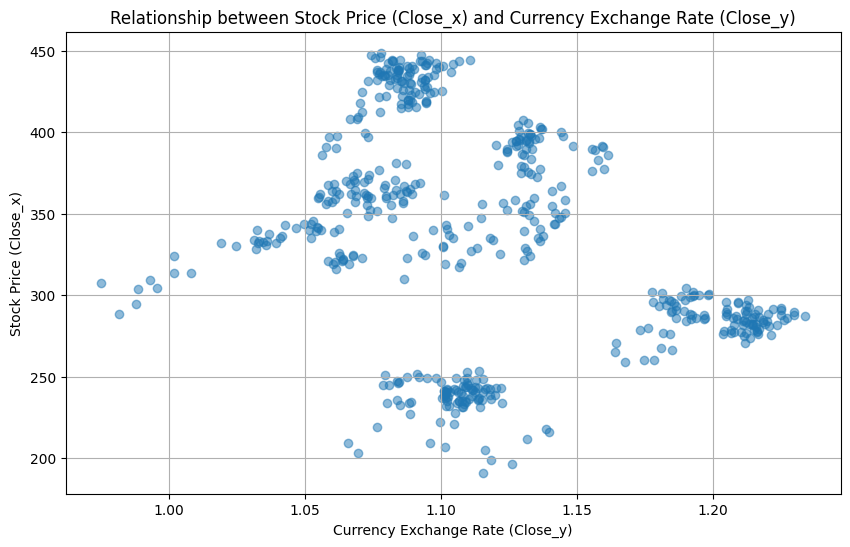

In [21]:
# Plot the relationship between stock price (Close_x) and currency exchange rate (Close_y)
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Close_y'], merged_df['Close_x'], alpha=0.5)
plt.title('Relationship between Stock Price (Close_x) and Currency Exchange Rate (Close_y)')
plt.xlabel('Currency Exchange Rate (Close_y)')
plt.ylabel('Stock Price (Close_x)')
plt.grid(True)
plt.show()


# Result breakdown

**Significance of the Factor:** The p-value is very small, indicating that the currency exchange rate has a statistically significant effect on the stock price

**F-Stat:** The F-stat suggests that the model explains a significant portion of the variability in the stock price

# Scatter Plot

